In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


In [3]:
print('Пропущенных значений:', X.isnull().sum().sum())
print('Категориальных переменных:', X.select_dtypes(exclude='float64').shape[1])

Пропущенных значений: 0
Категориальных переменных: 0


In [4]:
from sklearn.model_selection import train_test_split

np.random.seed(225)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [6]:
ks = [1, 3, 5, 10, 15, 25]

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train[['alcohol', 'magnesium']])
scaled_X_test = scaler.transform(X_test[['alcohol', 'magnesium']])
models = {}

for k in ks:
    classifier = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    classifier.fit(scaled_X_train, y_train)
    models[k] = classifier
    train_score = classifier.score(scaled_X_train, y_train)
    test_score = classifier.score(scaled_X_test, y_test)
    print(f"NN: {k:.0f}  Train: {train_score:.2%}  Test: {test_score:.2%}")

NN: 1  Train: 99.19%  Test: 61.11%
NN: 3  Train: 82.26%  Test: 70.37%
NN: 5  Train: 79.84%  Test: 66.67%
NN: 10  Train: 76.61%  Test: 70.37%
NN: 15  Train: 78.23%  Test: 68.52%
NN: 25  Train: 75.00%  Test: 66.67%


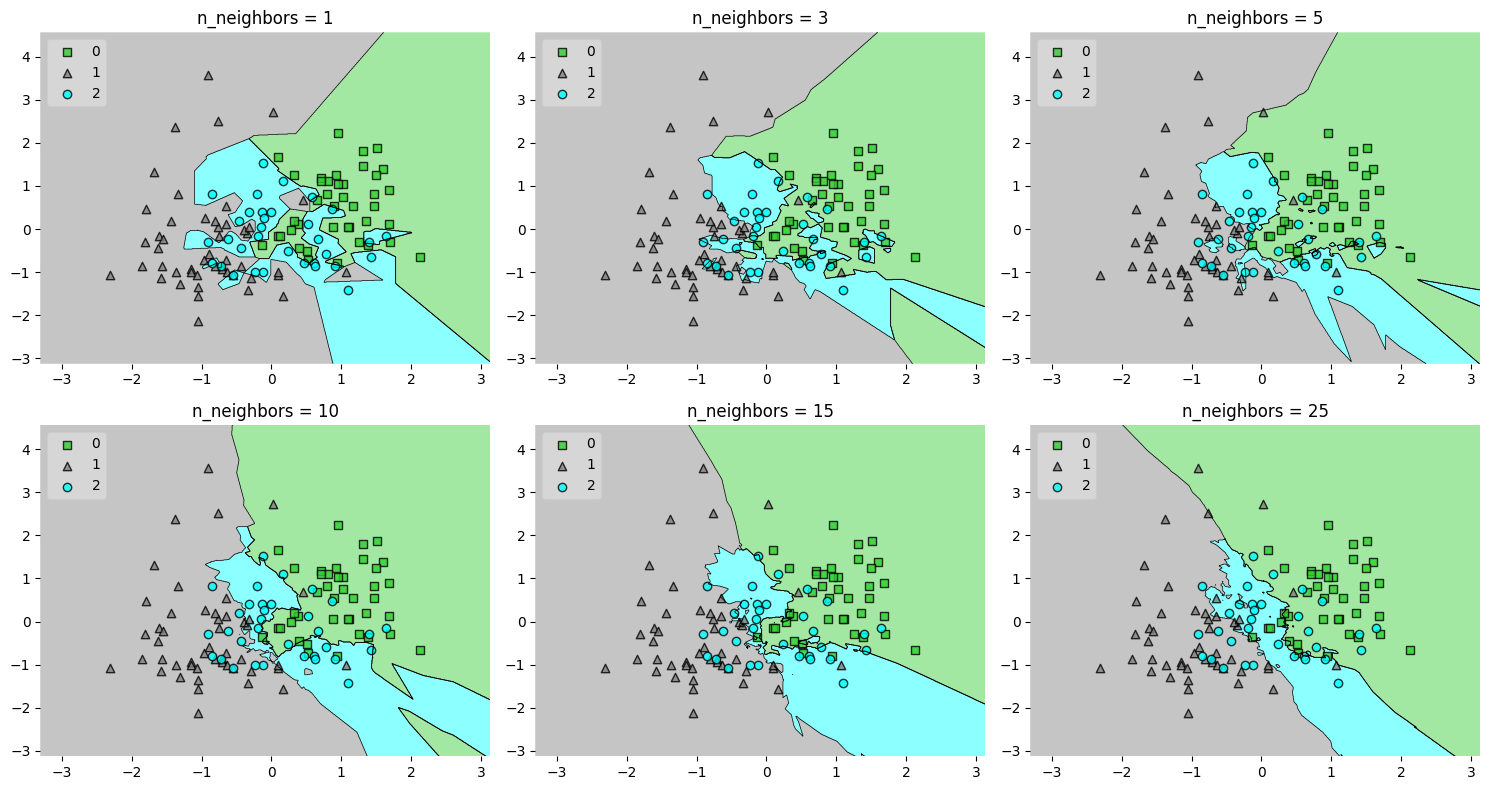

In [7]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

ncols = min(3, int(np.ceil(np.sqrt(len(models))))) 
nrows = int(np.ceil(len(models) / ncols))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)

fig = plt.figure(figsize=(15, nrows * 4))

labels = [f'n_neighbors = {x}' for x in models.keys()]

for i, (model, label) in enumerate(zip(models.values(), labels)):
    row = int(i / ncols)
    column = i % ncols
    ax = plt.subplot(gs[row, column])
    fig = plot_decision_regions(X=scaled_X_train, y=y_train, clf=model, legend=2, colors='limegreen,gray,cyan')
    plt.title(label)

plt.tight_layout()
plt.show();

- Оптимально использовать метод 10 ближайших соседей, так как качество модели достаточно высокое на тестовой выборке, а переобучение гораздо меньше, чем у модели с 3 соседями (нет маленьких островков на графике вокруг одиноких элементов).
- Явно о переобучении модели говорят результаты с k равным 1 или 3, так как присутствуют области одного класса отдельно стоящих элементов на "территории" другого класса.

### KNN realisation by hand for fun

In [8]:
import numpy as np
from collections import Counter
import random

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      self.X = X
      self.y = y

    def predict(self, X):
      elems = X.shape[0]
      distances = self.count_distance(X, self.X)

      k_nearest = np.argsort(distances, axis=1)[:, :self.k]

      predictions = []
      for i in range(elems):
        cl = self.y[k_nearest[i]]
        class_counts = Counter(cl)
        preds = class_counts.most_common(1)

        if len(preds) == 1:
            prediction = preds[0][0]
        else:
            prediction = random.choice(preds)[0]
            
        predictions.append(prediction)

      return np.array(predictions)
    
    def count_distance(self, x, y):
      if len(x.shape) == 1:
        x = x.reshape(-1, x.shape[0])
      distances = np.linalg.norm(x[:, np.newaxis] - y, axis=2)
      return distances

In [9]:
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [10]:
test_knn(KNN)

### [Diamonds Dataset](https://www.kaggle.com/shivam2503/diamonds). Regressions.

In [11]:
data = pd.read_csv('data/data_4/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [12]:
print('Пропущенных значений:', data.isnull().sum().sum())
data.drop(columns=['Unnamed: 0'], inplace=True)

Пропущенных значений: 0


In [13]:
data.corr(numeric_only=True)['price'].sort_values(ascending=False)

price    1.000000
carat    0.921591
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth   -0.010647
Name: price, dtype: float64

Больше всего с ценой коррелируют вес в каратах, длина, ширина и высота в миллиметрах.

In [14]:
data = pd.get_dummies(data, dtype=np.int8, drop_first=True)

In [15]:
X = data.drop(columns=['price'])
y = data['price']

In [16]:
from sklearn.model_selection import train_test_split

np.random.seed(225)

bins = pd.cut(y, bins=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=bins)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error

linreg_mse = mean_squared_error(y_test, test_preds)
print(f'MSE на train: {mean_squared_error(y_train, train_preds)}, MSE на test: {linreg_mse}')

MSE на train: 1288068.716007049, MSE на test: 1254521.353844899


In [20]:
coefs_linreg = dict(zip(X.columns, model.coef_))

In [21]:
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso(alpha=10)
ridge_model = Ridge(alpha=10)

lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train);

In [22]:
print('Веса Lasso')
dict(zip(X.columns, lasso_model.coef_))

Веса Lasso


{'carat': 4786.686358132541,
 'depth': -83.53939734939291,
 'table': -67.78290526208197,
 'x': -483.19786789069775,
 'y': -0.0,
 'z': -169.841462754087,
 'cut_Good': 45.0324834480842,
 'cut_Ideal': 211.25594940525392,
 'cut_Premium': 145.14752928297705,
 'cut_Very Good': 141.01421440270772,
 'color_E': -10.430402345317379,
 'color_F': -38.43206606791286,
 'color_G': -120.15733801993049,
 'color_H': -284.91046819005754,
 'color_I': -373.7098645902961,
 'color_J': -465.33082756555285,
 'clarity_IF': 653.9906961162285,
 'clarity_SI1': 874.5610292544654,
 'clarity_SI2': 409.36451162132624,
 'clarity_VS1': 1042.6137660667605,
 'clarity_VS2': 1109.4292379830633,
 'clarity_VVS1': 848.3070774850424,
 'clarity_VVS2': 972.5812942100334}

In [23]:
print('Веса Ridge')
dict(zip(X.columns, ridge_model.coef_))

Веса Ridge


{'carat': 5239.7979338753485,
 'depth': -70.3239911769727,
 'table': -56.97488478349827,
 'x': -868.6285198492651,
 'y': 18.715318848666744,
 'z': -213.8476628985555,
 'cut_Good': 164.10527791380764,
 'cut_Ideal': 407.6633517943208,
 'cut_Premium': 324.2109525492725,
 'cut_Very Good': 303.35749807967454,
 'color_E': -81.07002090270207,
 'color_F': -105.03018424886463,
 'color_G': -197.59935536161362,
 'color_H': -356.7359365466159,
 'color_I': -444.0152306335657,
 'color_J': -523.7171968606131,
 'clarity_IF': 933.9800786977149,
 'clarity_SI1': 1532.9962059529391,
 'clarity_SI2': 982.952925233888,
 'clarity_VS1': 1598.90160482981,
 'clarity_VS2': 1755.2914807675375,
 'clarity_VVS1': 1240.9970371841048,
 'clarity_VVS2': 1427.2296742232354}

Веса carat и x поменялись в меньшую сторону, но всё так же остаются на порядок больше других. Похоже, что проблема мультиколлинеарности не стояло настолько остро, как можно было бы предположить.

In [24]:
alpha = [0.1, 1, 10, 100, 200]
lasso_models, ridge_models, lasso_norms, ridge_norms = [], [], [], []
for a in alpha:
    lasso_model = Lasso(alpha=a)
    ridge_model = Ridge(alpha=a)

    lasso_model.fit(X_train, y_train)
    ridge_model.fit(X_train, y_train)

    lasso_models.append(lasso_model)
    ridge_models.append(ridge_model)
    
    lasso_norms.append(np.linalg.norm(lasso_model.coef_))
    ridge_norms.append(np.linalg.norm(ridge_model.coef_))

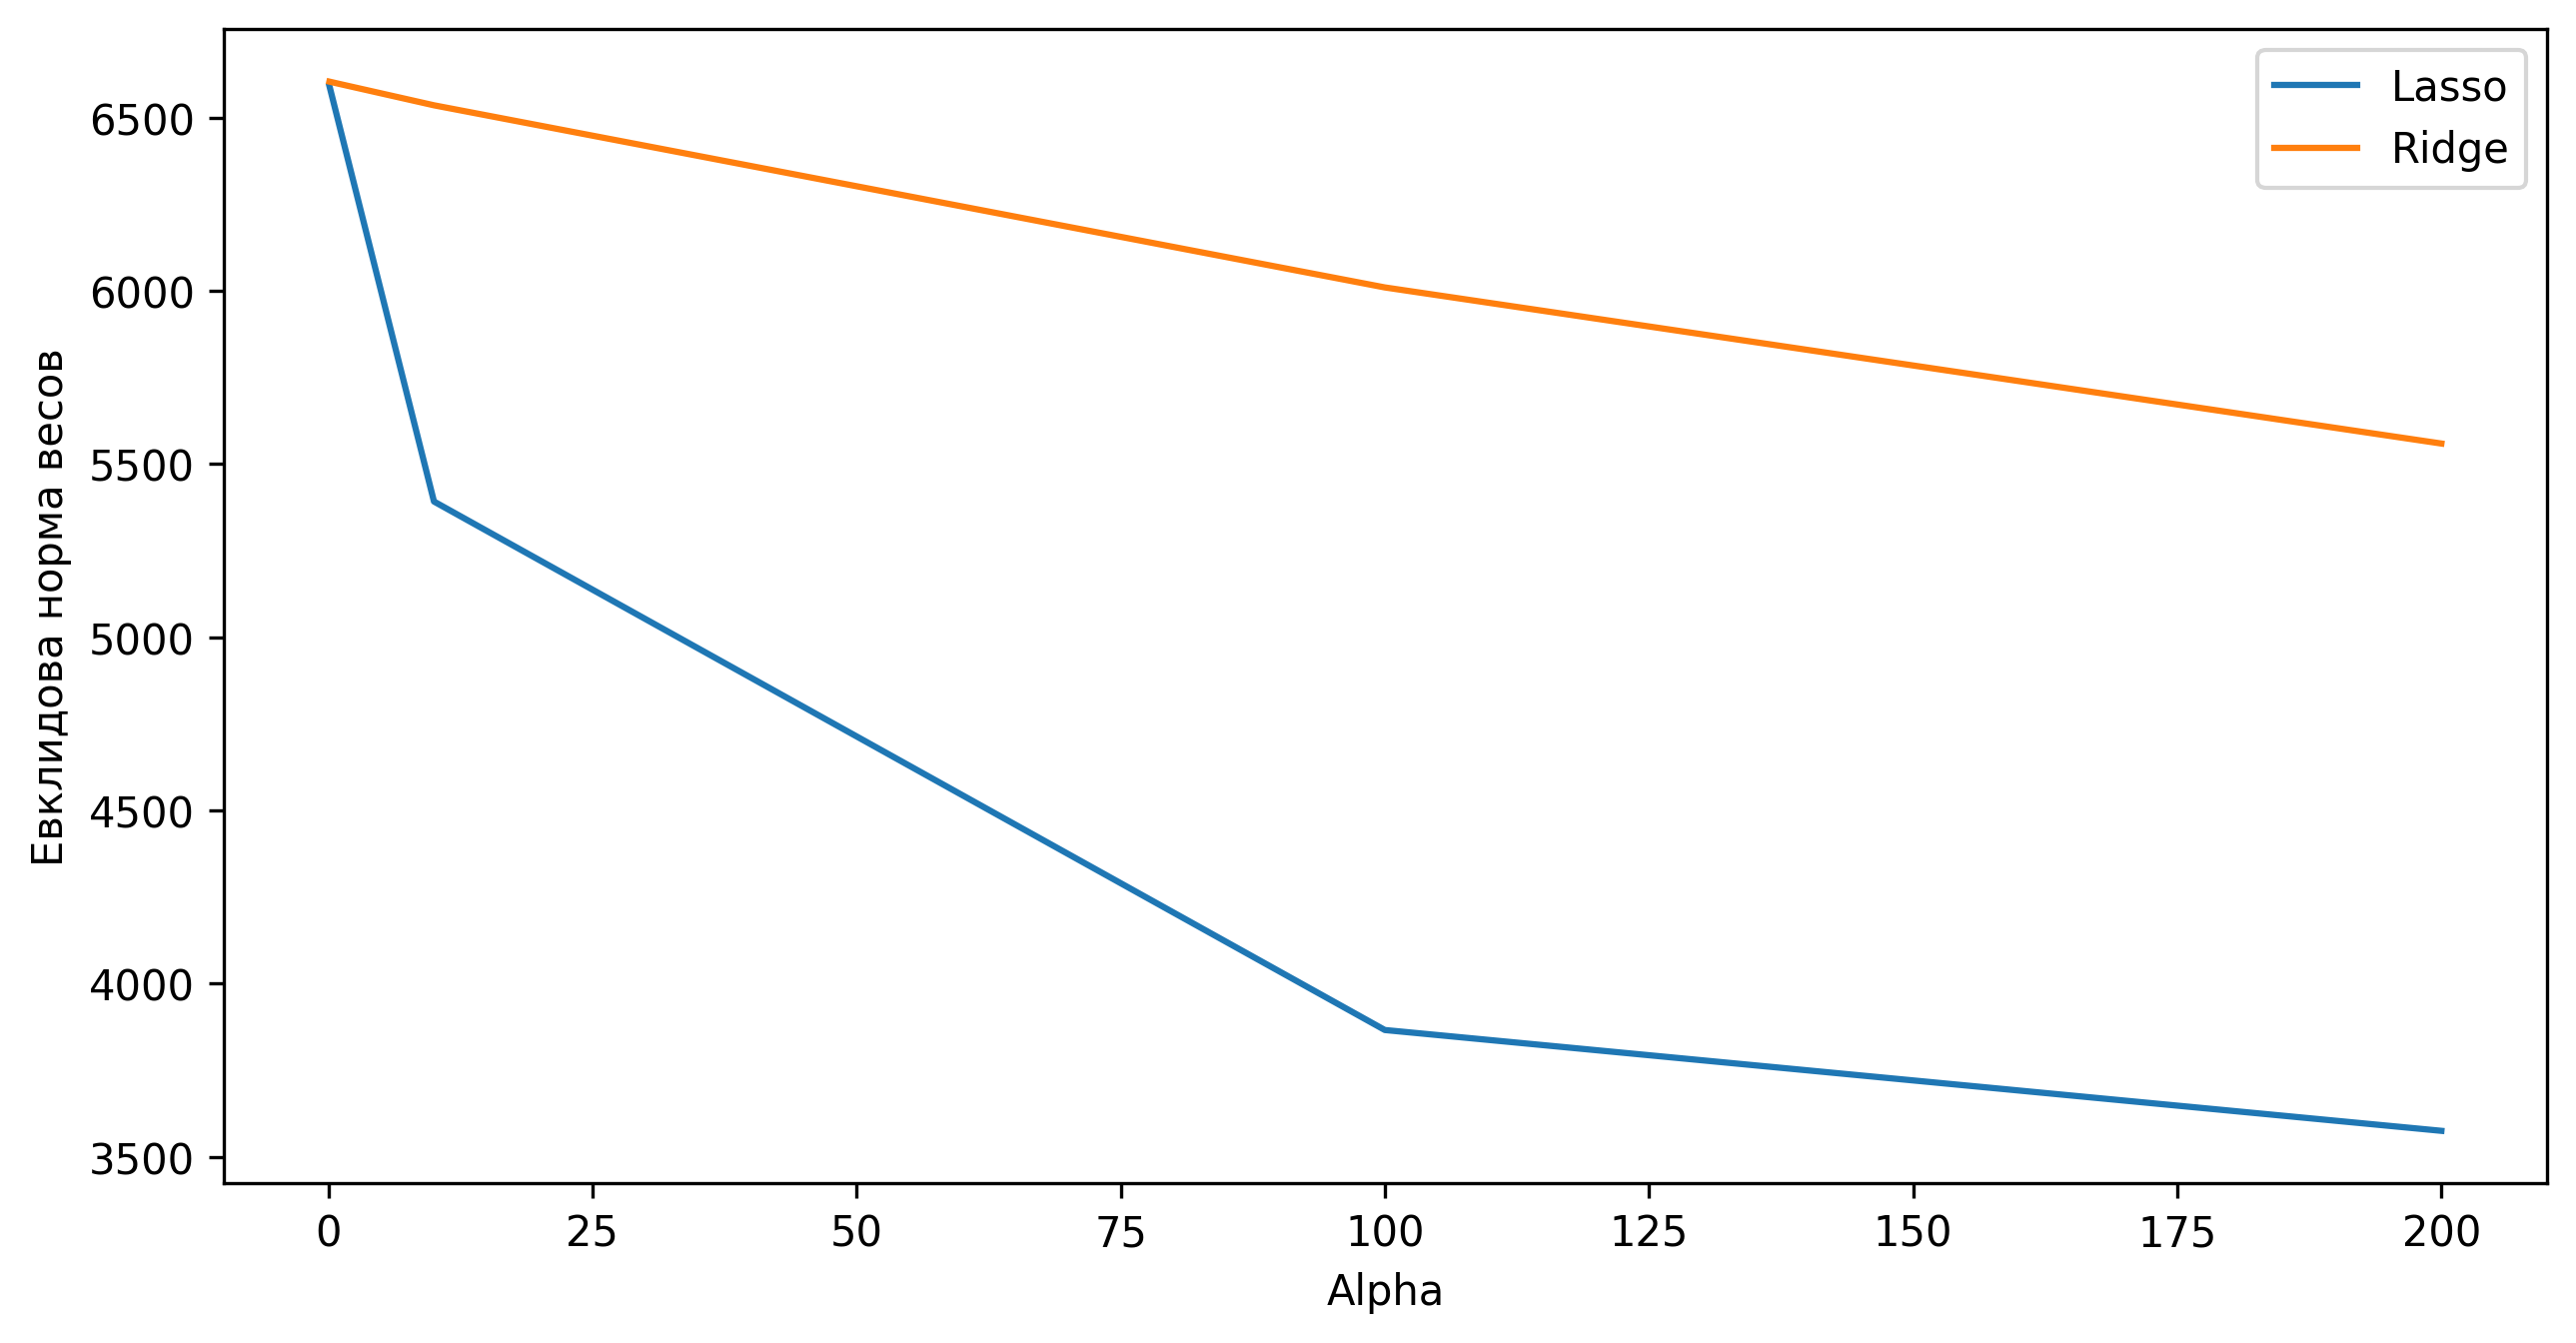

In [25]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(alpha, lasso_norms, label="Lasso")
plt.plot(alpha, ridge_norms, label="Ridge")
plt.xlabel("Alpha")
plt.ylabel("Евклидова норма весов")
plt.legend()
plt.show()

In [26]:
from sklearn.linear_model import LassoCV

lassocv_model = LassoCV(alphas=alpha, cv=len(alpha))
lassocv_model.fit(X_train, y_train);

In [27]:
print(dict(zip(lassocv_model.alphas_, [np.mean(x) for x in lassocv_model.mse_path_])))

{200.0: 2179654.0035940763, 100.0: 1801262.0685710702, 10.0: 1349249.7337669032, 1.0: 1292585.6010964885, 0.1: 1292223.0593724486}


In [28]:
final_lasso = Lasso(alpha=0.1)
final_lasso.fit(X_train, y_train)
coefs_lasso = dict(zip(X.columns, final_lasso.coef_))

- Самым информативным оказался признак вес в каратах. Одна из главных метрик драгоценных камней, поэтому неудивительно.
- Оценки чистоты алмаза тоже очень информативны. Примеси других минералов в камне не ценятся, потому оценка по этому параметру сразу влияет на цену.
- Длина информативна, потому что важен размер камня.

In [29]:
y_lasso_pred = final_lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_lasso_pred)
lasso_mse

1254501.183790766

In [30]:
res_mse = lasso_mse - linreg_mse
print('Улучшение качества модели после применения Lasso-регрессии по MSE:', res_mse)
print('Улучшение качества модели после применения Lasso-регрессии по MSE, % от изначальной:', (res_mse / linreg_mse) * 100)

Улучшение качества модели после применения Lasso-регрессии по MSE: -20.170054133050144
Улучшение качества модели после применения Lasso-регрессии по MSE, % от изначальной: -0.001607788824895829
